In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# using inspect to see tables
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [6]:
# use inspect to get column names in measurement table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# use inspect to get column names in station table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# reflect an existing database into a new model
Base = automap_base()

In [9]:
# reflect the tables
Base.prepare(autoload_with=engine)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()


('2017-08-23',)

In [14]:
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(measurement.date, measurement.prcp ).\
                  filter(measurement.date > query_date).order_by(measurement.date).all()
#precip_scores

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_scores, columns=['date', 'precipitation'])
#dates = precip_df['date']
precip_df.set_index('date', inplace=True)


# Sort the dataframe by date
precip_df = precip_df.sort_values('date')
precip_df.head()



# Use Pandas Plotting with Matplotlib to plot the data

precip_df.plot.bar(rot=90, figsize=(8, 6))
plt.xticks(rotation="vertical")


plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('precipitation')
plt.show()

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


In [ ]:
base = datetime.datetime(2005, 2, 1)
dates = [base + datetime.timedelta(hours=(2 * i)) for i in range(732)]
N = len(dates)
np.random.seed(19680801)
y = np.cumsum(np.random.randn(N))

fig, axs = plt.subplots(3, 1, layout='constrained', figsize=(6, 6))
lims = [(np.datetime64('2005-02'), np.datetime64('2005-04')),
        (np.datetime64('2005-02-03'), np.datetime64('2005-02-15')),
        (np.datetime64('2005-02-03 11:00'), np.datetime64('2005-02-04 13:20'))]
for nn, ax in enumerate(axs):
    ax.plot(dates, y)
    ax.set_xlim(lims[nn])
    # rotate_labels...
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_horizontalalignment('right')
axs[0].set_title('Default Date Formatter')
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
session.query(measurement.station).distinct().count()

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(measurement.station, func.count(measurement.date)).\
group_by(measurement.station).order_by(func.count(measurement.date).desc()).all()
# List the stations and their counts in descending order.
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

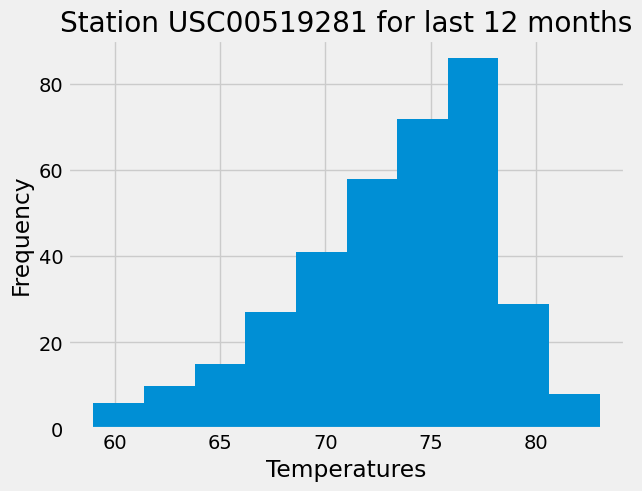

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data = session.query(measurement.tobs).\
                  filter(measurement.date >= query_date).filter(measurement.station == 'USC00519281').\
                    all()
temp_data
temp_df = pd.DataFrame(temp_data, columns=['temperature'])
temp_df 


temperatures = temp_df['temperature']
plt.hist(temperatures)
plt.xlabel('Temperatures')
plt.ylabel('Frequency')
plt.title('Station USC00519281 for last 12 months')
plt.show()

# Close Session

In [21]:
# Close Session
session.close()